## Dependencies

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
from astroquery.gaia import Gaia
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import ssl
from mpl_toolkits.mplot3d import Axes3D




Status messages could not be retrieved


## Optimization of image  

In [4]:

"""
https://github.com/ashley-ferreira/WACO/blob/main/WACO_notebook.ipynb
"""

import numpy
import math

def sky_median_sig_clip(input_arr, sig_fract, percent_fract, max_iter=100, low_cut=True, high_cut=True):
	"""Estimating a sky value for a given number of iterations

	@type input_arr: numpy array
	@param input_arr: image data array
	@type sig_fract: float
	@param sig_fract: fraction of sigma clipping
	@type percent_fract: float
	@param percent_fract: convergence fraction
	@type max_iter: integer
	@param max_iter: max. of iterations
	@type low_cut: boolean
	@param low_cut: cut out only low values
	@type high_cut: boolean
	@param high_cut: cut out only high values
	@rtype: tuple
	@return: (sky value, number of iterations)

	"""
	work_arr = numpy.ravel(input_arr)
	old_sky = numpy.median(work_arr)
	sig = work_arr.std()
	upper_limit = old_sky + sig_fract * sig
	lower_limit = old_sky - sig_fract * sig
	if low_cut and high_cut:
		indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
	else:
		if low_cut:
			indices = numpy.where((work_arr > lower_limit))
		else:
			indices = numpy.where((work_arr < upper_limit))
	work_arr = work_arr[indices]
	new_sky = numpy.median(work_arr)
	iteration = 0
	while ((math.fabs(old_sky - new_sky)/new_sky) > percent_fract) and (iteration < max_iter) :
		iteration += 1
		old_sky = new_sky
		sig = work_arr.std()
		upper_limit = old_sky + sig_fract * sig
		lower_limit = old_sky - sig_fract * sig
		if low_cut and high_cut:
			indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
		else:
			if low_cut:
				indices = numpy.where((work_arr > lower_limit))
			else:
				indices = numpy.where((work_arr < upper_limit))
		work_arr = work_arr[indices]
		new_sky = numpy.median(work_arr)
	return (new_sky, iteration)



def sky_mean_sig_clip(input_arr, sig_fract, percent_fract, max_iter=100, low_cut=True, high_cut=True):
	"""Estimating a sky value for a given number of iterations

	@type input_arr: numpy array
	@param input_arr: image data array
	@type sig_fract: float
	@param sig_fract: fraction of sigma clipping
	@type percent_fract: float
	@param percent_fract: convergence fraction
	@type max_iter: integer
	@param max_iter: max. of iterations
	@type low_cut: boolean
	@param low_cut: cut out only low values
	@type high_cut: boolean
	@param high_cut: cut out only high values
	@rtype: tuple
	@return: (sky value, number of iterations)

	"""
	work_arr = numpy.ravel(input_arr)
	old_sky = numpy.mean(work_arr)
	sig = work_arr.std()
	upper_limit = old_sky + sig_fract * sig
	lower_limit = old_sky - sig_fract * sig
	if low_cut and high_cut:
		indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
	else:
		if low_cut:
			indices = numpy.where((work_arr > lower_limit))
		else:
			indices = numpy.where((work_arr < upper_limit))
	work_arr = work_arr[indices]
	new_sky = numpy.mean(work_arr)
	iteration = 0
	while ((math.fabs(old_sky - new_sky)/new_sky) > percent_fract) and (iteration < max_iter) :
		iteration += 1
		old_sky = new_sky
		sig = work_arr.std()
		upper_limit = old_sky + sig_fract * sig
		lower_limit = old_sky - sig_fract * sig
		if low_cut and high_cut:
			indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
		else:
			if low_cut:
				indices = numpy.where((work_arr > lower_limit))
			else:
				indices = numpy.where((work_arr < upper_limit))
		work_arr = work_arr[indices]
		new_sky = numpy.mean(work_arr)
	return (new_sky, iteration)



def range_from_zscale(input_arr, contrast = 1.0, sig_fract = 3.0, percent_fract = 0.01, max_iter=100, low_cut=True, high_cut=True):
	"""Estimating ranges with the zscale algorithm

	@type input_arr: numpy array
	@param input_arr: image data array as sample pixels to derive z-ranges
	@type contrast: float
	@param contrast: zscale contrast which should be larger than 0.
	@type sig_fract: float
	@param sig_fract: fraction of sigma clipping
	@type percent_fract: float
	@param percent_fract: convergence fraction
	@type max_iter: integer
	@param max_iter: max. of iterations
	@type low_cut: boolean
	@param low_cut: cut out only low values
	@type high_cut: boolean
	@param high_cut: cut out only high values
	@rtype: tuple
	@return: (min. value, max. value, number of iterations)

	"""
	work_arr = numpy.ravel(input_arr)
	work_arr = numpy.sort(work_arr) # sorting is done.
	max_ind = len(work_arr) - 1
	midpoint_ind = int(len(work_arr)*0.5)
	I_midpoint = work_arr[midpoint_ind]
	print(".. midpoint index ", midpoint_ind, " I_midpoint ", I_midpoint)
	# initial estimation of the slope
	x = numpy.array(range(0, len(work_arr))) - midpoint_ind
	y = numpy.array(work_arr)
	temp = numpy.vstack([x, numpy.ones(len(x))]).T
	slope, intercept = numpy.linalg.lstsq(temp, y)[0]
	old_slope = slope
	print("... slope & intercept ", old_slope, " ", intercept)
	# initial clipping
	sig = y.std()
	upper_limit = I_midpoint + sig_fract * sig
	lower_limit = I_midpoint - sig_fract * sig
	if low_cut and high_cut:
		indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
	else:
		if low_cut:
			indices = numpy.where((work_arr > lower_limit))
		else:
			indices = numpy.where((work_arr < upper_limit))
	# new estimation of the slope
	x = numpy.array(indices[0]) - midpoint_ind
	y = numpy.array(work_arr[indices])
	temp = numpy.vstack([x, numpy.ones(len(x))]).T
	slope, intercept = numpy.linalg.lstsq(temp, y)[0]
	new_slope = slope
	print("... slope & intercept ", new_slope, " ", intercept)
	iteration = 1
	# to run the iteration, we need more than 50% of the original input array
	while (((math.fabs(old_slope - new_slope)/new_slope) > percent_fract) and (iteration < max_iter)) and (len(y) >= midpoint_ind) :
		iteration += 1
		old_slope = new_slope
		# clipping
		sig = y.std()
		upper_limit = I_midpoint + sig_fract * sig
		lower_limit = I_midpoint - sig_fract * sig
		if low_cut and high_cut:
			indices = numpy.where((work_arr < upper_limit) & (work_arr > lower_limit))
		else:
			if low_cut:
				indices = numpy.where((work_arr > lower_limit))
			else:
				indices = numpy.where((work_arr < upper_limit))
		# new estimation of the slope
		x = numpy.array(indices[0]) - midpoint_ind
		y = work_arr[indices]
		temp = numpy.vstack([x, numpy.ones(len(x))]).T
		slope, intercept = numpy.linalg.lstsq(temp, y)[0]
		new_slope = slope
		print("... slope & intercept ", new_slope, " ", intercept)

	z1 = I_midpoint + (new_slope / contrast) * (0 - midpoint_ind)
	z2 = I_midpoint + (new_slope / contrast) * (max_ind - midpoint_ind)

	return (z1, z2, iteration)



def range_from_percentile(input_arr, low_cut=0.25, high_cut=0.25):
	"""Estimating ranges with given percentiles

	@type input_arr: numpy array
	@param input_arr: image data array as sample pixels to derive ranges
	@type low_cut: float
	@param low_cut: cut of low-value pixels
	@type high_cut: float
	@param high_cut: cut of high-value pixels
	@rtype: tuple
	@return: (min. value, max. value)

	"""
	work_arr = numpy.ravel(input_arr)
	work_arr = numpy.sort(work_arr) # sorting is done.
	size_arr = len(work_arr)
	low_size = int(size_arr * low_cut)
	high_size = int(size_arr * high_cut)
	
	z1 = work_arr[low_size]
	z2 = work_arr[size_arr - 1 - high_size]

	return (z1, z2)



def histeq(inputArray, scale_min=None, scale_max=None, num_bins=512):
	"""Performs histogram equalisation of the input numpy array.
    
	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@type num_bins: int
	@param num_bins: number of bins in which to perform the operation (e.g. 512)
	@rtype: numpy array
	@return: image data array
    
	"""		
    
	imageData=numpy.array(inputArray, copy=True)
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	imageData.clip(min=scale_min, max=scale_max)
	imageData = (imageData -scale_min) / (scale_max - scale_min) # now between 0 and 1.
	indices = numpy.where(imageData < 0)
	imageData[indices] = 0.0
    
	# histogram equalisation: we want an equal number of pixels in each intensity range
	image_histogram, histogram_bins = numpy.histogram(imageData.flatten(), bins=num_bins, range=(0.0, 1.0), density=True)
	histogram_cdf = image_histogram.cumsum()
	histogram_cdf = histogram_cdf / histogram_cdf[-1] # normalization

	# mapping the image values to the histogram bins
	imageData_temp = numpy.interp(imageData.flatten(), histogram_bins[:-1], histogram_cdf)
	imageData = imageData_temp.reshape(imageData.shape)
       
	return imageData



def linear(inputArray, scale_min=None, scale_max=None):
	"""Performs linear scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
	print("img_scale : linear")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()

	imageData.clip(min=scale_min, max=scale_max)
	imageData = (imageData -scale_min) / (scale_max - scale_min)
	indices = numpy.where(imageData < 0)
	imageData[indices] = 0.0
	
	return imageData


def sqrt(inputArray, scale_min=None, scale_max=None):
	"""Performs sqrt scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : sqrt")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()

	imageData.clip(min=scale_min, max=scale_max)
	imageData = imageData - scale_min
	indices = numpy.where(imageData < 0)
	imageData[indices] = 0.0
	imageData = numpy.sqrt(imageData)
	imageData = imageData / math.sqrt(scale_max - scale_min)
	
	return imageData


def log(inputArray, scale_min=None, scale_max=None):
	"""Performs log10 scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : log")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor = math.log10(scale_max - scale_min)
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	try :
		imageData[indices1] = numpy.log10(imageData[indices1])/factor
	except :
		print("Error on math.log10 for ", (imageData[i][j] - scale_min))

	return imageData


def power(inputArray, power_index=3.0, scale_min=None, scale_max=None):
	"""Performs power scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type power_index: float
	@param power_index: power index
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : power")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor = 1.0 / math.pow((scale_max - scale_min), power_index)
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	imageData[indices1] = numpy.power((imageData[indices1] - scale_min), power_index)*factor

	return imageData


def asinh(inputArray, scale_min=None, scale_max=None, non_linear=2.0):
	"""Performs asinh scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@type non_linear: float
	@param non_linear: non-linearity factor
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : asinh")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor = numpy.arcsinh((scale_max - scale_min)/non_linear)
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	imageData[indices1] = numpy.arcsinh((imageData[indices1] - scale_min)/non_linear)/factor

	return imageData


def logistic(inputArray, scale_min=None, scale_max=None, center=0.5, slope=1.0):
	"""Performs logistic scaling of the input numpy array.

	@type inputArray: numpy array
	@param inputArray: image data array
	@type scale_min: float
	@param scale_min: minimum data value
	@type scale_max: float
	@param scale_max: maximum data value
	@type center: float
	@param center: central value
	@type slope: float
	@param slope: slope
	@rtype: numpy array
	@return: image data array
	
	"""		
    
	print("img_scale : logistic")
	imageData=numpy.array(inputArray, copy=True)
	
	if scale_min == None:
		scale_min = imageData.min()
	if scale_max == None:
		scale_max = imageData.max()
	factor2 = 1.0/(1.0+1.0/math.exp((scale_max - center)/slope))
	factor2 = factor2 + 1.0/(1.0+1.0/math.exp((scale_min - center)/slope))
	factor2 = 1.0 / factor2
	factor1 = -1.0 * factor2 / (1.0+1.0/math.exp((scale_min - center)/slope))
	indices0 = numpy.where(imageData < scale_min)
	indices1 = numpy.where((imageData >= scale_min) & (imageData <= scale_max))
	indices2 = numpy.where(imageData > scale_max)
	imageData[indices0] = 0.0
	imageData[indices2] = 1.0
	imageData[indices1] = factor1 + factor2 / (1.0 + 1.0/numpy.exp((imageData[indices1] - center)/slope))

	return imageData

## Exploring Data

In [5]:
df = pd.read_csv("./data/planetary_system.csv", on_bad_lines='skip')


In [6]:
dtypes_df = pd.DataFrame(df.dtypes).reset_index()
dtypes_df.columns = ['Column', 'DataType']

pd.set_option('display.max_rows', None)  

print(dtypes_df)

pd.reset_option('display.max_rows')

             Column DataType
0           pl_name   object
1          hostname   object
2      default_flag    int64
3           sy_snum    int64
4           sy_pnum    int64
5   discoverymethod   object
6         disc_year    int64
7     disc_facility   object
8           soltype   object
9   pl_controv_flag    int64
10       pl_refname   object
11        pl_orbper  float64
12    pl_orbpererr1  float64
13    pl_orbpererr2  float64
14     pl_orbperlim  float64
15       pl_orbsmax  float64
16   pl_orbsmaxerr1  float64
17   pl_orbsmaxerr2  float64
18    pl_orbsmaxlim  float64
19          pl_rade  float64
20      pl_radeerr1  float64
21      pl_radeerr2  float64
22       pl_radelim  float64
23          pl_radj  float64
24      pl_radjerr1  float64
25      pl_radjerr2  float64
26       pl_radjlim  float64
27        pl_bmasse  float64
28    pl_bmasseerr1  float64
29    pl_bmasseerr2  float64
30     pl_bmasselim  float64
31        pl_bmassj  float64
32    pl_bmassjerr1  float64
33    pl_bmass

In [7]:
import pandas as pd
import json
import random

# Cargar el dataset
# df = pd.read_csv('tu_dataset.csv')  # Descomenta esta línea y ajusta el archivo según corresponda

# Verifica las columnas del DataFrame
print(df.columns)

# Seleccionar las columnas necesarias
selected_columns = {
    "name": "pl_name",
    "starName": "hostname",
    "orbitPer": "pl_orbper",
    "distance": "sy_dist",
    "planetTemp": "pl_eqt",
    "planetMass": "pl_bmasse",
    "discYear": "disc_year",
    "starTemp": "st_teff",
    "ra": "ra",
    "dec": "dec",
}

# Filtrar el dataframe para seleccionar las columnas necesarias
df_selected = df[list(selected_columns.values())]

# Reemplazar NaN con None
df_selected = df_selected.where(pd.notnull(df_selected), None)

# Eliminar filas con NaN en la distancia (sy_dist) para obtener exoplanetas con distancia conocida
df_selected = df_selected.dropna(subset=["sy_dist"])

# Ordenar por distancia para obtener los exoplanetas más cercanos
df_selected = df_selected.sort_values(by="sy_dist")

# Seleccionar los 50 exoplanetas más cercanos
df_selected = df_selected.head(50)

# Función para generar un color aleatorio en formato hexadecimal
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

# Generar el formato para MongoDB sin el campo _id
def generate_mongodb_format(row):
    return {
        "name": row["pl_name"],
        "starName": row["hostname"],
        "orbitPer": row["pl_orbper"],
        "distance": row["sy_dist"],
        "planetTemp": row["pl_eqt"],
        "planetMass": row["pl_bmasse"],
        "discYear": str(row["disc_year"]) if row["disc_year"] is not None else None,
        "starTemp": row["st_teff"],
        "ra": row["ra"],
        "dec": row["dec"],
        "color": random_color(),  # Asignar color aleatorio
        "__v": 0
    }

# Aplicar la función para convertir las filas a JSON
data_for_mongodb = df_selected.apply(generate_mongodb_format, axis=1).tolist()

# Guardar el JSON en un archivo
with open("exoplanetas_cercanos_sin_id.json", "w") as f:
    json.dump(data_for_mongodb, f, indent=4)

print("Se generó el archivo exoplanetas_cercanos_sin_id.json con los 50 exoplanetas cercanos.")


Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2

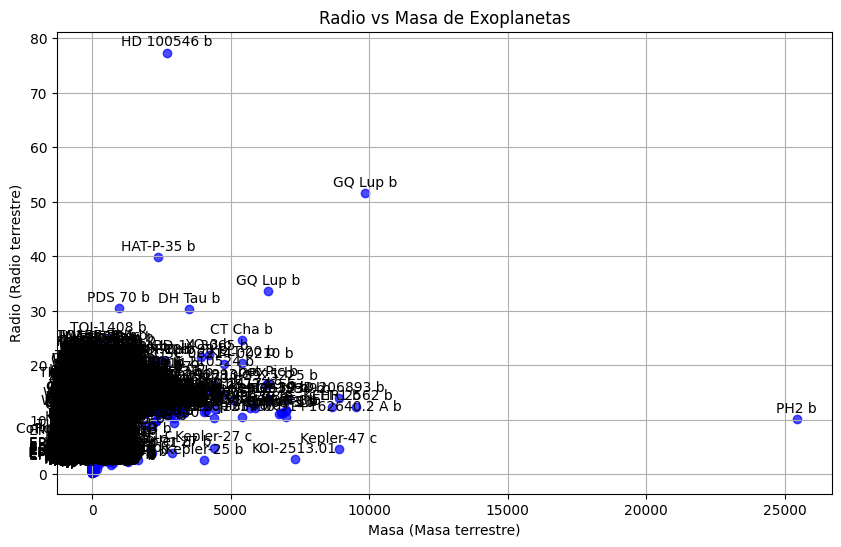

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['pl_bmasse'], df['pl_rade'], color='blue', alpha=0.7)

plt.title('Radio vs Masa de Exoplanetas')
plt.xlabel('Masa (Masa terrestre)')
plt.ylabel('Radio (Radio terrestre)')

for i in range(len(df)):
    plt.annotate(df['pl_name'][i], (df['pl_bmasse'][i], df['pl_rade'][i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid()
plt.show()

In [9]:

source = ColumnDataSource(df)

p = figure(title='Radio vs Masa de Exoplanetas',
           x_axis_label='Masa (Masa terrestre)',
           y_axis_label='Radio (Radio terrestre)',
           tools='pan, box_zoom, reset')

p.circle('pl_bmasse', 'pl_rade', size=10, source=source, fill_color='blue', line_color='black')

hover = HoverTool()
hover.tooltips = [("Nombre", "@pl_name"), ("Masa", "@pl_bmasse"), ("Radio", "@pl_rade")]
p.add_tools(hover)

show(p)

In [10]:
df.head(5)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
2,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2023-09-19,2023-08,2023-09-19
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23


In [11]:
grouped = df.groupby('pl_name').agg(list)

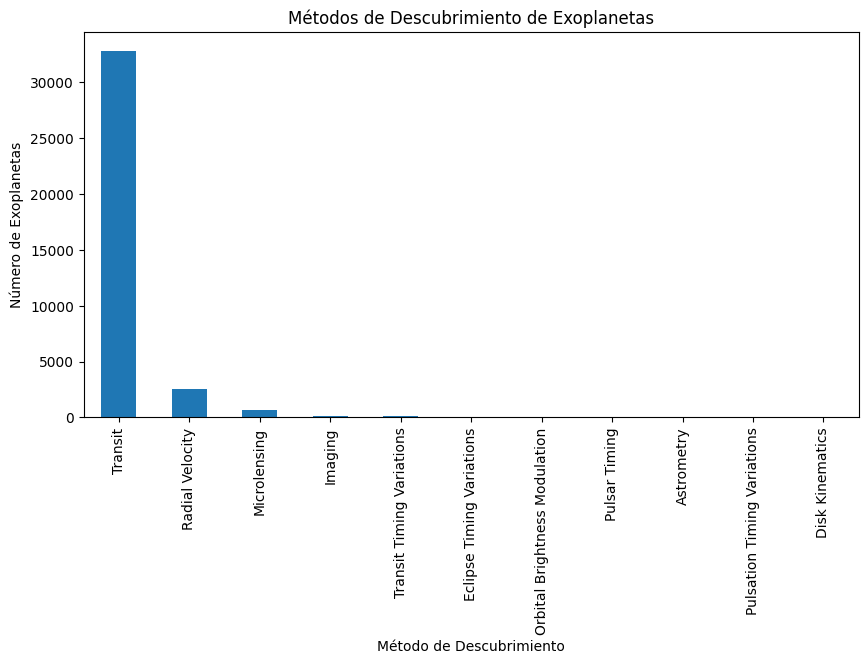

In [12]:
plt.figure(figsize=(10, 5))
df['discoverymethod'].value_counts().plot(kind='bar')
plt.title('Métodos de Descubrimiento de Exoplanetas')
plt.xlabel('Método de Descubrimiento')
plt.ylabel('Número de Exoplanetas')
plt.show()


In [13]:
total_exoplanetas = df['pl_name'].nunique()
print(f"Número total de exoplanetas: {total_exoplanetas}")

Número total de exoplanetas: 5759


##  Details of Exoplanet input 

In [14]:
nombre_exoplaneta = 'Kepler-37 b' 

In [15]:
exoplaneta = df[df['pl_name'] == nombre_exoplaneta]
exoplaneta

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
23930,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Kepler Project Candidate (q1_q17_dr25_sup_koi),0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2018-09-25,2018-08-16,2018-09-25
23931,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Published Confirmed,0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2018-04-25,2015-08,2015-05-21
23932,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Published Confirmed,0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2018-04-25,2014-02,2016-10-27
23933,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Published Confirmed,0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2018-09-04,2018-10,2018-09-06
23934,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Published Confirmed,0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2018-04-25,2013-02,2014-05-14
23935,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Published Confirmed,0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2019-04-16,2019-03,2019-04-18
23936,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Kepler Project Candidate (q1_q8_koi),0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2013-10-28,2014-01-08,2013-10-28
23937,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Kepler Project Candidate (q1_q12_koi),0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2014-11-18,2014-12-04,2014-11-18
23938,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Kepler Project Candidate (q1_q16_koi),0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2014-11-21,2014-12-18,2014-11-21
23939,Kepler-37 b,Kepler-37,0,1,4,Transit,2013,Kepler,Published Confirmed,0,...,-0.004,7.942,0.013,-0.013,9.54988,0.000258,-0.000258,2024-02-21,2024-01,2024-02-21


In [16]:
def buscar_exoplaneta(df, nombre_exoplaneta):
    exoplaneta = df[df['pl_name'] == nombre_exoplaneta]
    
    if not exoplaneta.empty:
        exoplaneta_confirmado = exoplaneta[exoplaneta['soltype'].str.contains('Published Confirmed', na=False)]
        
        if not exoplaneta_confirmado.empty:
            ultimo_exoplaneta = exoplaneta_confirmado.sort_values(by='rowupdate', ascending=False).iloc[0]
            sistema_planetario = exoplaneta['hostname'].nunique()
            return ultimo_exoplaneta, sistema_planetario
    return None, None

In [17]:
nombre_exoplaneta = 'Kepler-37 b' 
exoplaneta_info, sistema_planetario = buscar_exoplaneta(df, nombre_exoplaneta)

if exoplaneta_info is not None:
    print(exoplaneta_info)
    print(f'El exoplaneta {nombre_exoplaneta} pertenece al sistema planetario: {sistema_planetario}')
else:
    print(f'No se encontró el exoplaneta {nombre_exoplaneta}.')

pl_name           Kepler-37 b
hostname            Kepler-37
default_flag                0
sy_snum                     1
sy_pnum                     4
                     ...     
sy_gaiamagerr1       0.000258
sy_gaiamagerr2      -0.000258
rowupdate          2024-02-21
pl_pubdate            2024-01
releasedate        2024-02-21
Name: 23939, Length: 92, dtype: object
El exoplaneta Kepler-37 b pertenece al sistema planetario: 1


#### GAIA INFO

In [18]:
exoplaneta_info

pl_name           Kepler-37 b
hostname            Kepler-37
default_flag                0
sy_snum                     1
sy_pnum                     4
                     ...     
sy_gaiamagerr1       0.000258
sy_gaiamagerr2      -0.000258
rowupdate          2024-02-21
pl_pubdate            2024-01
releasedate        2024-02-21
Name: 23939, Length: 92, dtype: object

In [19]:
if not exoplaneta.empty:
    ra = exoplaneta['ra'].values[0] 
    dec = exoplaneta['dec'].values[0]
    distancia = exoplaneta['sy_dist'].values[0]  

    print(f"Coordenadas del exoplaneta {nombre_exoplaneta}:")
    print(f"RA: {ra} grados, Dec: {dec} grados, Distancia: {distancia} parsecs")
else:
    print("Exoplaneta no encontrado.")

Coordenadas del exoplaneta Kepler-37 b:
RA: 284.0592503 grados, Dec: 44.5183733 grados, Distancia: 63.9207 parsecs


## GAIA integration

In [20]:

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def obtener_datos_gaia(ra, dec, rango=0.1):
    query = f"""
    SELECT *
    FROM gaiaedr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra}, {dec}, {rango})
    ) = 1
    """
    job = Gaia.launch_job(query)
    return job.get_results()

In [21]:
ssl._create_default_https_context = ssl._create_unverified_context
gaia_data = obtener_datos_gaia(ra,dec)

gaia_data

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 2106626173871134464,2106626173871134464,1140524751,2016.0,284.08118684473953,0.22208916,44.42115648567398,0.26639158,0.036372358397143964,0.25616074,0.14199036,2.2585561,-1.2468960860127756,0.27314135,-1.8831691219650841,0.31088313,-0.19602877,-0.0927456,-0.12029337,0.13284923,0.10972043,0.122250214,-0.28722984,-0.03822033,0.01268579,-0.10835513,359,0,358,1,-0.6239682,348.6428,0.0,2.142367e-15,95,False,--,1.4567369,0.070616186,-0.031811118,-0.018449808,0.070840515,-0.20866872,-0.05556553,41,26,0.45011038,44,20,1,0.01593087,60.03114,0,0,0.97563636,0.21605942,0.12900715,0.106913894,0.11373827,-98.80452,59.49669,-2.9259782,30.05759,False,359,259.18360467171846,0.81312174,318.75128,19.653349,33,119.53414788291032,6.581508,18.16212,20.144812,32,194.74872908681667,6.741346,28.888702,19.024208,0,2,0,0,0,1.2125878,1.1206036,0.4914627,0.62914085,--,--,0,--,--,--,74.34767373250504,17.794430980987247,295.9430349679888,66.59673879805561
1636042515805110273,Gaia EDR3 2106626242590626176,2106626242590626176,170288735,2016.0,284.11197338318794,0.32959557,44.42869401441631,0.41902947,0.1630752018

In [22]:
def graficar_exoplaneta(exoplaneta, gaia_data):
    plt.figure(figsize=(10, 10))
    plt.scatter(gaia_data['ra'], gaia_data['dec'], color='blue', s=1, label='Estrellas de Gaia')
    plt.scatter(exoplaneta['ra'], exoplaneta['dec'], color='red', label='Exoplaneta')
    plt.title(f'Ubicación de {exoplaneta["pl_name"]}')
    plt.xlabel('RA (degrees)')
    plt.ylabel('Dec (degrees)')
    plt.legend()
    plt.grid()
    plt.show()


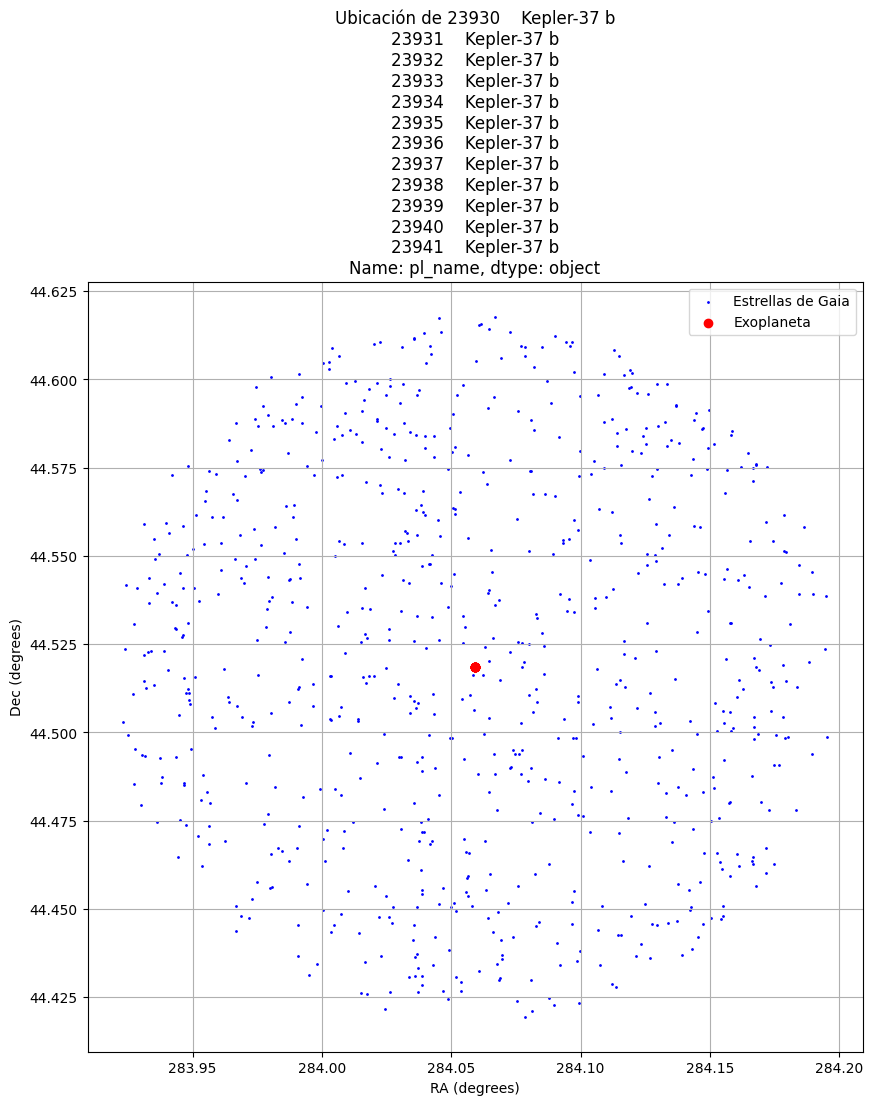

In [23]:
graficar_exoplaneta(exoplaneta, gaia_data)


In [24]:

def graficar_exoplaneta_3d(exoplaneta, gaia_data):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    distance = 1  

    ra_rad = np.radians(gaia_data['ra'])
    dec_rad = np.radians(gaia_data['dec'])
    
    x_stars = distance * np.cos(dec_rad) * np.cos(ra_rad)
    y_stars = distance * np.cos(dec_rad) * np.sin(ra_rad)
    z_stars = distance * np.sin(dec_rad)

    ax.scatter(x_stars, y_stars, z_stars, color='blue', s=1, label='Estrellas de Gaia')

    ra_exoplaneta = np.radians(exoplaneta['ra'])
    dec_exoplaneta = np.radians(exoplaneta['dec'])

    x_exoplaneta = distance * np.cos(dec_exoplaneta) * np.cos(ra_exoplaneta)
    y_exoplaneta = distance * np.cos(dec_exoplaneta) * np.sin(ra_exoplaneta)
    z_exoplaneta = distance * np.sin(dec_exoplaneta)

    ax.scatter(x_exoplaneta, y_exoplaneta, z_exoplaneta, color='red', s=100, label='Exoplaneta')

    ax.set_title(f'Ubicación de {exoplaneta["pl_name"]} en 3D')
    ax.set_xlabel('X (cartesiano)')
    ax.set_ylabel('Y (cartesiano)')
    ax.set_zlabel('Z (cartesiano)')
    ax.legend()
    ax.grid()

    plt.show()


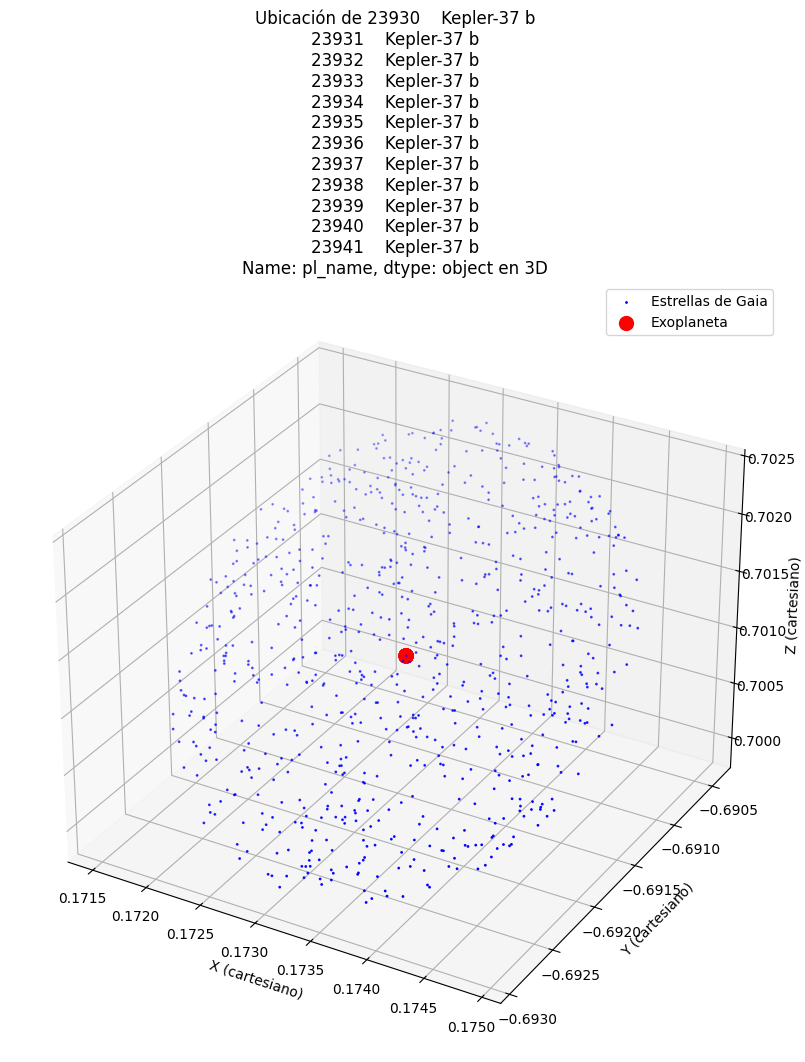

In [25]:
graficar_exoplaneta_3d(exoplaneta, gaia_data)
